In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder 


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor



## Made by : ADAM TIOVA BUDHIHARJO

# **FINDING BEST MODEL FOR APARTMENT SALE PRICE PREDICTION**

# **Introduction**

#### Setting the right price for an apartment is crucial in a city like Daegu, where the housing market is highly dynamic and competitive. Due to their good location and facilities, apartments are the most common choice for many people. However, the challenge lies in determining a suitable price that enables sellers to make reasonable profits while remaining competitive. The size, age, and distance of an apartment from key points such as schools and subway stations are factors that influence its selling price. When pricing, these factors force sellers—whether individuals or real estate businesses—to strike a balance. Underpricing leads to lost opportunities, while overpricing risks leaving the property unsold for longer periods.

## **Model Performance and Metrics**

#### One key metric used in evaluating the performance of predictive models is the Mean Absolute Percentage Error (MAPE). MAPE measures the accuracy of predictions as a percentage, making it easier to interpret in practical terms.

## **What MAPE Represents**

#### MAPE provides a clear indication of the model's prediction accuracy. For example, a MAPE score of 10% implies that, on average, the model's predictions are off by about 10% from the actual prices. In practical terms, if an apartment's actual selling price is 200000 Rupiah, the predicted price might typically deviate by about 20000 Rupiah (which is 10% of 200000). The lower the MAPE, the more accurate the model is in its predictions.

## **Why MAPE is Important**

#### MAPE is particularly useful in business scenarios because it is easy to understand and communicate to stakeholders who may not have a deep technical background. Unlike other metrics, MAPE directly shows the percentage error, making it easier to discuss in terms of financial impact. This makes it an ideal metric for pricing models, where understanding the margin of error in monetary terms is crucial for decision-making.


## **Problem Statement**

#### In Daegu's competitive housing market, many sellers struggle with determining the optimal listing price for their apartments. This challenge is exacerbated by the multitude of factors that influence apartment prices, such as location, size, and proximity to key amenities. Without a data-driven approach, sellers may either overprice their apartments, resulting in extended time on the market, or underprice them, leading to lost revenue. Therefore, there is a pressing need for a reliable predictive model that can help sellers accurately estimate apartment prices, enabling them to set competitive prices that attract buyers and maximize returns.

## **Objective**

#### The primary objective of this model is to provide sellers with a reliable tool to estimate apartment prices in Daegu. By doing so, it will enable them to set competitive prices that attract buyers while maximizing their returns. 

In [13]:
df = pd.read_csv('data_daegu_apartment.csv')
df

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


# **Summarize data for each coloumn in the dataset**

In [14]:
# Initialize the list for feature summary
feature_summary_list = []

# Function to calculate outliers and extremes
def calculate_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    extremes = series[(series < extreme_lower_bound) | (series > extreme_upper_bound)]
    
    return len(outliers), len(extremes), len(outliers) / len(series) * 100, len(extremes) / len(series) * 100

# Loop through each feature to gather required information
for col in df.columns:
    data_type = df[col].dtype
    nan_count = df[col].isna().sum()
    nan_percentage = nan_count / len(df) * 100
    unique_values = df[col].unique()
    unique_no = len(df[col].unique())
    
    if pd.api.types.is_numeric_dtype(df[col]):
        outliers, extremes, outlier_percentage, extreme_percentage = calculate_outliers(df[col].dropna())
    else:
        outliers, extremes, outlier_percentage, extreme_percentage = 0, 0, 0, 0

    feature_summary_list.append({
        'Feature': col,
        'Data Type': data_type,
        'NaN': nan_count,
        'NaN %': nan_percentage,
        'Unique': unique_values,
        'Unique No': unique_no,
        'Outlier (1.5xIQR)': outliers,
        'Extreme (3xIQR)': extremes,
        'Outlier %': outlier_percentage,
        'Extreme %': extreme_percentage
    })

# Convert the list to a DataFrame
feature_summary = pd.DataFrame(feature_summary_list)

feature_summary


,Feature,Data Type,NaN,NaN %,Unique,Unique No,Outlier (1.5xIQR),Extreme (3xIQR),Outlier %,Extreme %
0,HallwayType,object,0,0.0,"[terraced, mixed, corridor]",3,0,0,0.000000,0.0
1,TimeToSubway,object,0,0.0,"[0-5min, 10min~15min, 15min~20min, 5min~10min,...",5,0,0,0.000000,0.0
2,SubwayStation,object,0,0.0,"[Kyungbuk_uni_hospital, Chil-sung-market, Bang...",8,0,0,0.000000,0.0
3,N_FacilitiesNearBy(ETC),float64,0,0.0,"[0.0, 1.0, 5.0, 2.0]",4,0,0,0.000000,0.0
4,N_FacilitiesNearBy(PublicOffice),float64,0,0.0,"[3.0, 5.0, 7.0, 1.0, 4.0, 2.0, 6.0, 0.0]",8,0,0,0.000000,0.0
5,N_SchoolNearBy(University),float64,0,0.0,"[2.0, 1.0, 3.0, 4.0, 5.0, 0.0]",6,0,0,0.000000,0.0
6,N_Parkinglot(Basement),float64,0,0.0,"[1270.0, 0.0, 56.0, 798.0, 536.0, 605.0, 203.0...",20,0,0,0.000000,0.0
7,YearBuilt,int64,0,0.0,"[2007, 1986, 1997, 2005, 2006, 2009, 2014, 199...",16,0,0,0.000000,0.0
8,N_FacilitiesInApt,int64,0,0.0,"[10, 4, 5, 7, 2, 9, 8, 1, 3]",9,0,0,0.000000,0.0
9,Size(sqf),int64,0,0.0,"[1387, 914, 558, 1743, 1334, 572, 910, 288, 11...",89,98,0,2.376910,0.0


### - No NaN values
### - Almost all coloumns don't have outlier, except for `Size(sqf)` and `SalePrice`

# **Check histogram for coloumns with outliers**

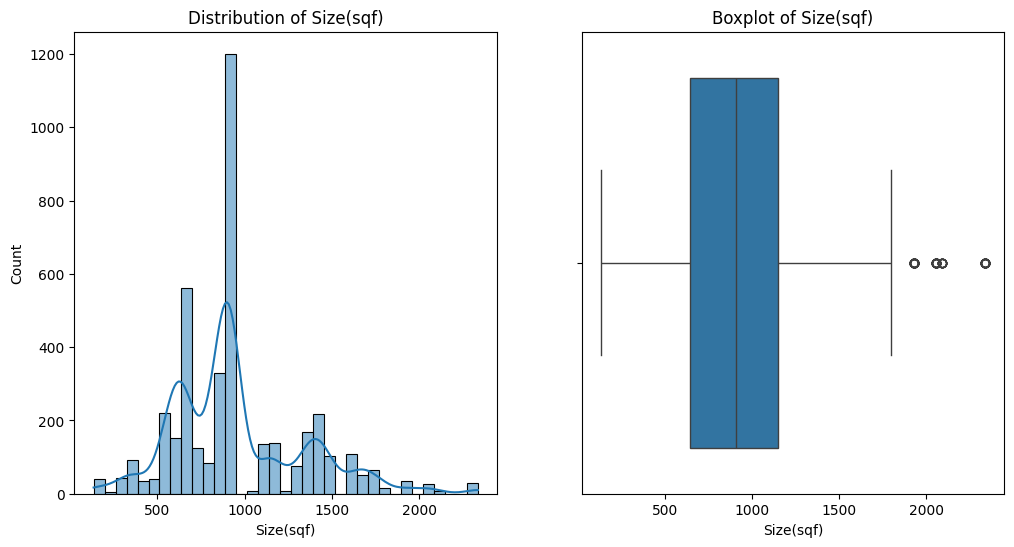

Text(0.5, 1.0, 'Boxplot of SalePrice')

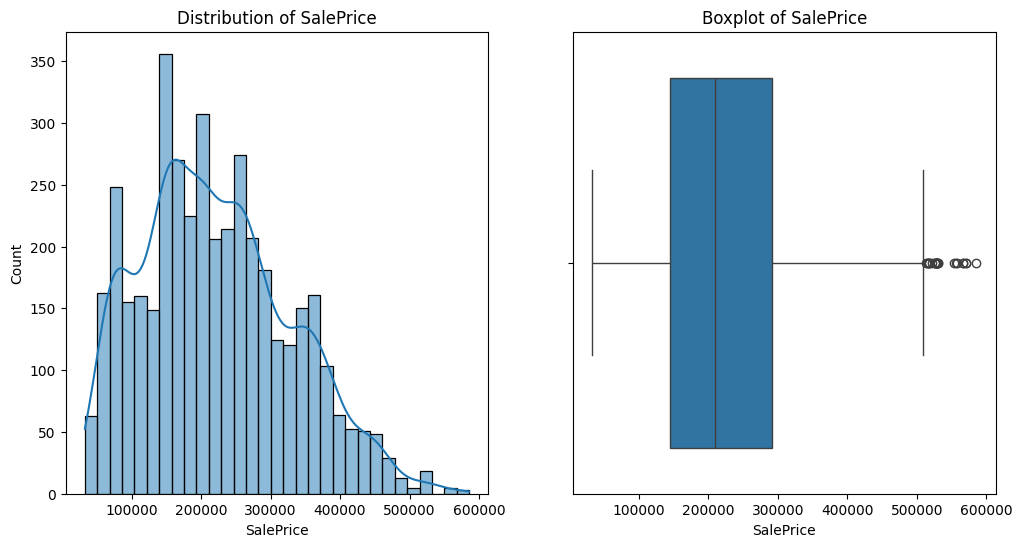

In [15]:

# Plot histogram and boxplot for Size(sqf)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Size(sqf)'], kde=True)
plt.title('Distribution of Size(sqf)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Size(sqf)'])
plt.title('Boxplot of Size(sqf)')

plt.show()

# Similarly, for SalePrice
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['SalePrice'])
plt.title('Boxplot of SalePrice')


## Based on these plots, the outliers are not extreme and seems to imply on the high end luxury apartments. Hence we will leave it be. Furthermore, it is also very low percentages, less than 3%

# **Check effect of each coloumn to target: Correlation & Chi Contingency**

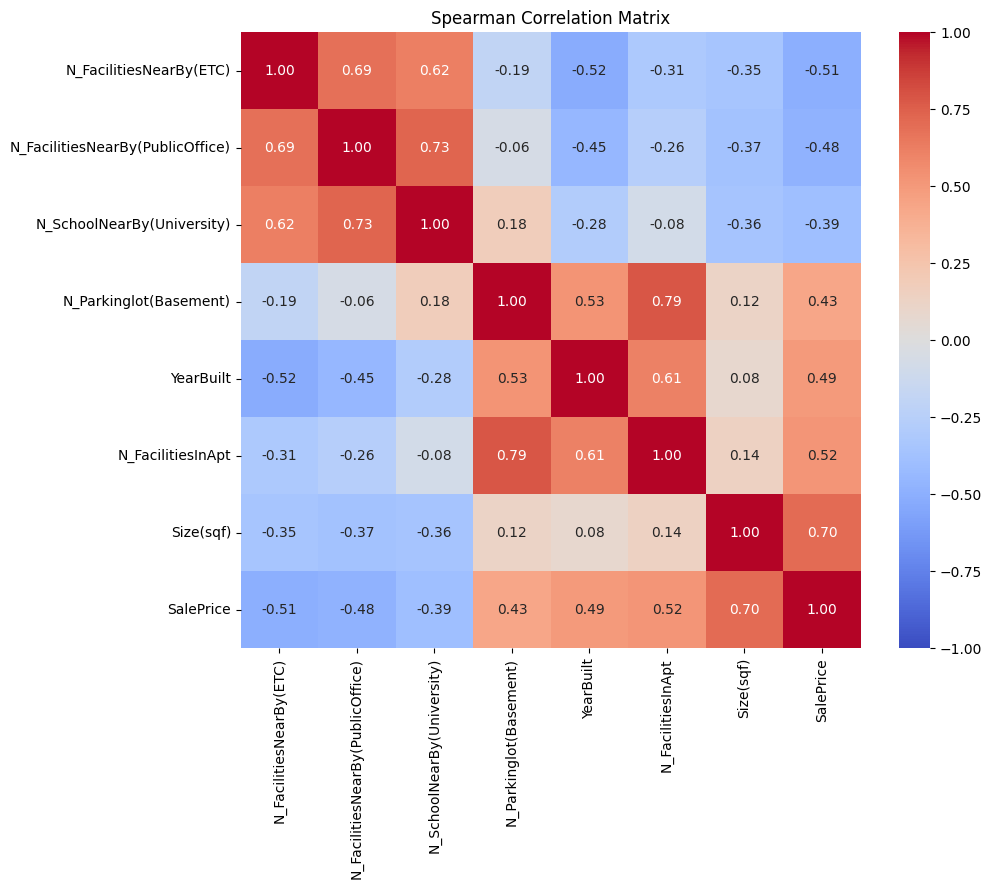

,Feature,Spearman Correlation with SalePrice
0,SalePrice,1.000000
1,Size(sqf),0.704138
2,N_FacilitiesInApt,0.519243
3,YearBuilt,0.494631
4,N_Parkinglot(Basement),0.433011
5,N_SchoolNearBy(University),-0.392807
6,N_FacilitiesNearBy(PublicOffice),-0.482899
7,N_FacilitiesNearBy(ETC),-0.506539


In [16]:
# Filter out only numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate the Spearman correlation matrix
spearman_corr_matrix = df[numerical_columns].corr(method='spearman')

# Plot the Spearman correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix')
plt.show()

# Specifically look at the Spearman correlation with SalePrice
spearman_correlation_with_target = spearman_corr_matrix['SalePrice'].sort_values(ascending=False)

# Convert to DataFrame
spearman_correlation_df = spearman_correlation_with_target.reset_index()
spearman_correlation_df.columns = ['Feature', 'Spearman Correlation with SalePrice']

# Display the DataFrame
spearman_correlation_df


### All coloumns seems to have linear significance affecting `SalePrice`. Significant: < -0,2 or > 0.2

In [17]:
# Function to perform Chi-Square test
def chi_square_test(data, target, feature):
    contingency_table = pd.crosstab(data[feature], target)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Apply Chi-Square test to each categorical feature
categorical_features = ['HallwayType', 'TimeToSubway', 'SubwayStation']
chi_square_results = {}

for feature in categorical_features:
    chi2, p = chi_square_test(df, df['SalePrice'], feature)
    chi_square_results[feature] = {'Chi2': chi2, 'p-value': p}

# Convert results to DataFrame for better visualization
chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index')

# Define the significance level
significance_level = 0.05

# Add a new column to indicate whether the feature affects the target
chi_square_df['Affects SalePrice'] = chi_square_df['p-value'] < significance_level

# Display the DataFrame
chi_square_df


,Chi2,p-value,Affects SalePrice
HallwayType,4977.485212,0.0,True
TimeToSubway,7595.164978,0.0,True
SubwayStation,11029.351305,0.0,True


### All categorical coloumn seems to be affecting `SalePrice`

## **EDA**

# **1. Distribution Visualisation**

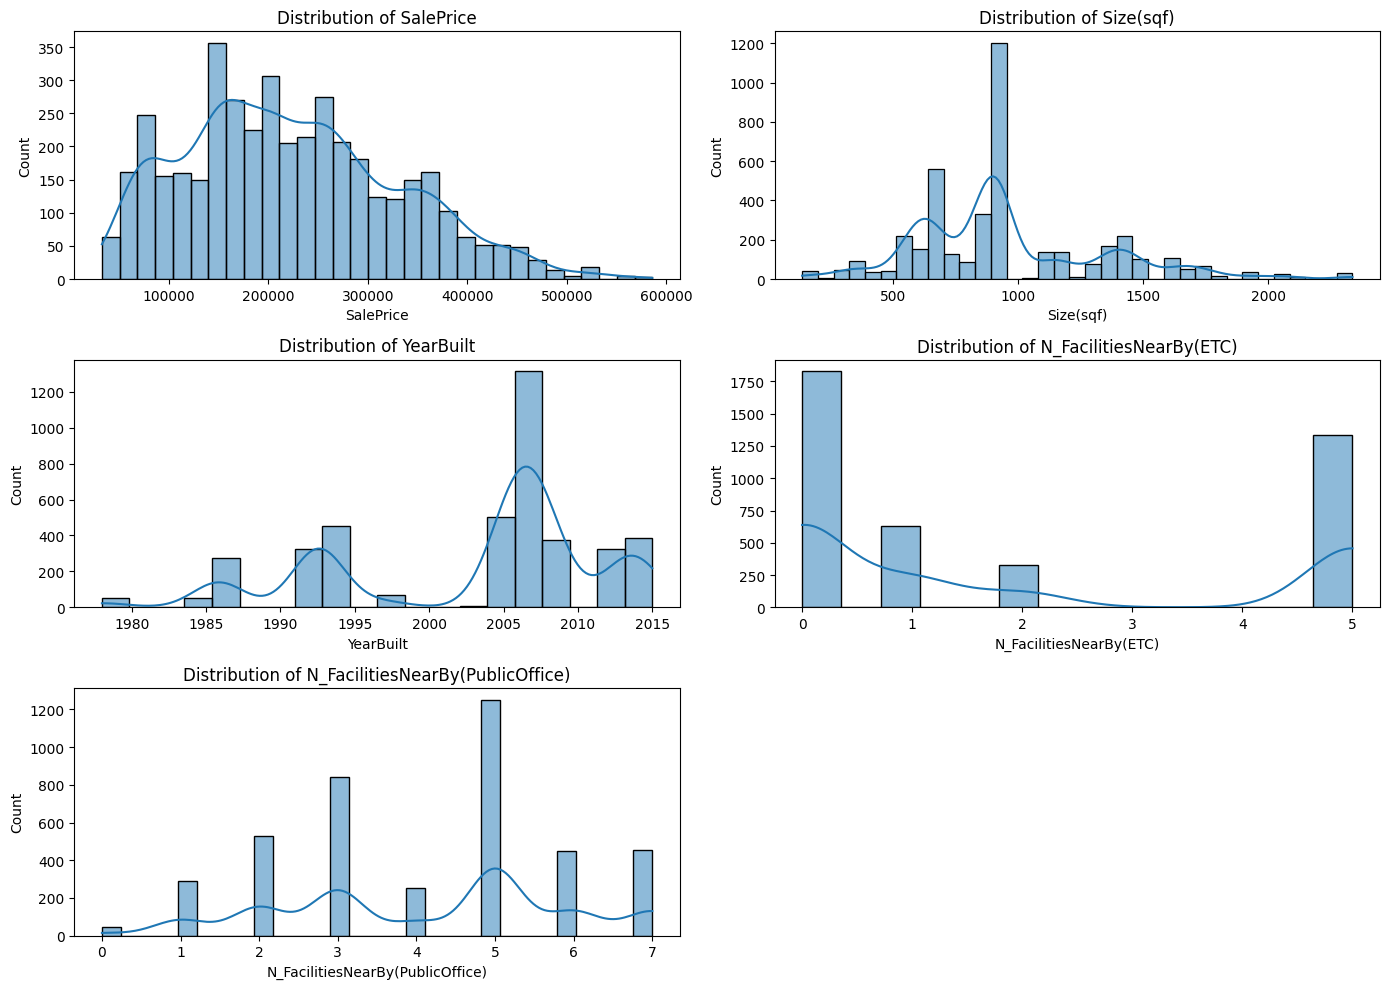

In [18]:
# Visualize the distribution of the target variable and key numerical features
features_to_plot = ['SalePrice', 'Size(sqf)', 'YearBuilt', 'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)']

# Define the number of rows and columns for subplots
n_rows = len(features_to_plot) // 2 + len(features_to_plot) % 2
n_cols = 2

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

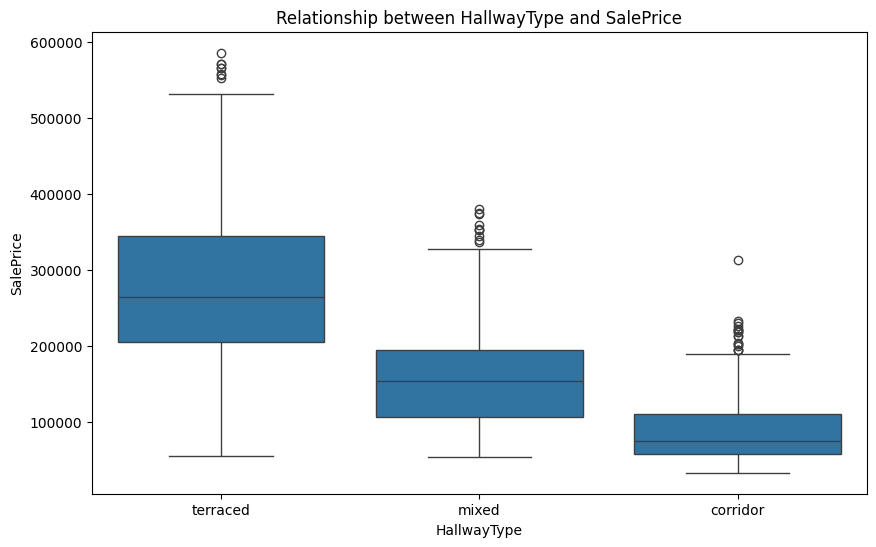

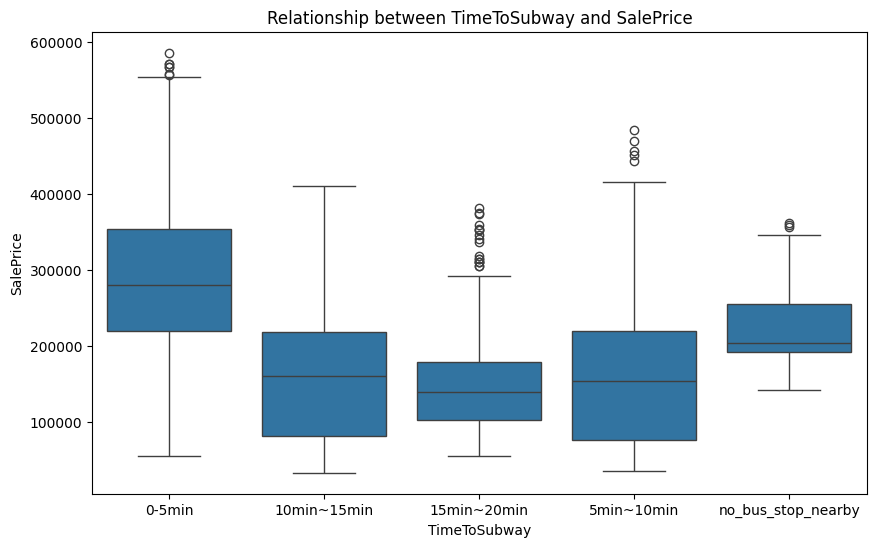

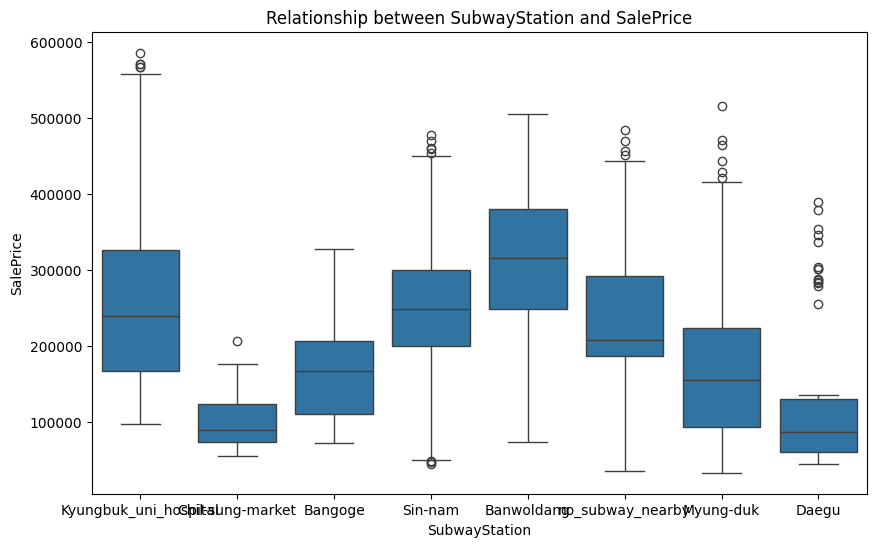

In [19]:
# Box plot to show the relationship between categorical features and SalePrice
categorical_features = ['HallwayType', 'TimeToSubway', 'SubwayStation']

for feature in categorical_features: #for loop for the mentioned above
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'Relationship between {feature} and SalePrice')
    plt.show()

In [20]:
# Calculate VIF for each numerical feature
X_numerical = df[numerical_columns].drop(columns=['SalePrice'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numerical.columns
vif_data['VIF'] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

vif_data

,Feature,VIF
0,N_FacilitiesNearBy(ETC),5.474361
1,N_FacilitiesNearBy(PublicOffice),15.342707
2,N_SchoolNearBy(University),18.284972
3,N_Parkinglot(Basement),12.254853
4,YearBuilt,34.327180
5,N_FacilitiesInApt,27.840728
6,Size(sqf),8.567090


## **1= no correlation, 2-5 = moderate, 6-10 = high correlation, >10 = very high correlation**
### Generally features that have high colinearity means that it has strong connection with another feature, which may disturb model learning
### Feature with high VIF:
- more than 10 = `YearBuilt`, `N_FacilitiesInApt`, `N_SchoolNearBy(University)`, `N_FacilitiesNearBy(PublicOffice)`, `N_Parkinglot(Basement)`
- 6 -10 = `Size(sqf)`, `N_FacilitiesNearBy(ETC)`

## Test to remove highest VIF and see the impact on new VIF

In [21]:
# Drop the columns with high VIF values
df_reduced = df.drop(columns=['N_FacilitiesInApt', 'N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)'])

# Update the list of numerical columns (excluding 'SalePrice')
numerical_columns_reduced = df_reduced.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns_reduced.remove('SalePrice')

# Recalculate VIFs for the remaining features
X_reduced = df_reduced[numerical_columns_reduced]
vif_data_reduced = pd.DataFrame()
vif_data_reduced['Feature'] = X_reduced.columns
vif_data_reduced['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

# Display the new VIF values
vif_data_reduced

,Feature,VIF
0,N_FacilitiesNearBy(ETC),1.950962
1,N_Parkinglot(Basement),3.027025
2,YearBuilt,11.186519
3,Size(sqf),8.132798


# removing `N_FacilitiesInApt`, `N_SchoolNearBy(University)`, `N_FacilitiesNearBy(PublicOffice)` seems to reduce VIF significantly. so we will not use these features for our model prediction

# **Preprocessing: Make Cleaning, Encoding and Scaling pipeline**

### Explanation of the Code

In this section, I’ve set up the data preprocessing steps and defined how different types of data will be handled before fitting the model. Here’s a breakdown of what each part of the code does:

1. **Dropping Unnecessary Columns**:
    - The first part of the code drops specific columns from the dataset that aren't needed for the model. We drop the columns `'N_FacilitiesInApt'`, `'N_SchoolNearBy(University)'`, and `'N_FacilitiesNearBy(PublicOffice)'`, along with the target variable `'SalePrice'` from `X`, because `'SalePrice'` is what we’re trying to predict, so it belongs in `y`.

2. **Categorical and Numerical Feature Separation**:
    - The categorical and numerical features are separated because they require different preprocessing steps:
        - `categorical_onehot_features`: These are categorical variables (like `'HallwayType'`) that will be one-hot encoded, meaning each category will be converted into its own binary column.
        - `categorical_ordinal_features`: These are ordinal features (like `'TimeToSubway'`), which have a natural order. They will be ordinally encoded, meaning each category is assigned a number based on its order.
        - `categorical_binary_features`: This is for categorical variables with many categories (like `'SubwayStation'`). Binary encoding reduces dimensionality by converting categories into a series of binary values.
        - `numerical_features`: These are numerical variables (like `'YearBuilt'`, `'Size(sqf)'`) that need to be standardized (scaled) to bring them to a common scale.

3. **Creating Transformers**:
    - For each type of feature, I create a specific transformer:
        - **Numerical Transformer**: Uses `StandardScaler` to standardize the numerical features.
        - **OneHotEncoder**: Encodes categorical features with a small number of categories into binary columns.
        - **OrdinalEncoder**: Encodes ordinal features, ensuring that their order is maintained.
        - **BinaryEncoder**: Encodes categorical features with many categories into a more compact form using binary encoding.

4. **ColumnTransformer**:
    - The `ColumnTransformer` is the key component that brings all the transformers together. It applies the appropriate transformer to each set of columns (numerical, one-hot encoded, ordinal, binary) and ensures that each column is processed correctly before being fed into the model.

5. **Preprocessor Pipeline**:
    - Finally, the `preprocessor` is a pipeline that automates all these preprocessing steps. Once the data is processed through this pipeline, it will be ready to be fed into the model (e.g., `LinearRegression`). This ensures consistency in how data is handled, reducing errors and improving the model’s performance.

This structured approach to preprocessing is crucial for preparing the data correctly, ensuring that both categorical and numerical data are properly transformed before modeling.


In [22]:
# List the columns you want to drop from X
drop_columns = ['N_FacilitiesInApt', 'N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)']  # Adjust this list as needed

# Define X by dropping the specified columns
X = df.drop(columns=drop_columns + ['SalePrice'])

# Define y (target variable)
y = df['SalePrice']

In [23]:
# Categorical columns
categorical_onehot_features = ['HallwayType']
categorical_ordinal_features = ['TimeToSubway']
categorical_binary_features = ['SubwayStation']

# Numerical columns (from the reduced set of features)
numerical_features = ['N_FacilitiesNearBy(ETC)', 'N_Parkinglot(Basement)', 'YearBuilt', 'Size(sqf)']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Preprocessing for categorical data
categorical_onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])

categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[['0-5min', '5min~10min', '10min~15min', '15min~20min']],
                               handle_unknown='use_encoded_value', unknown_value=-1))  # Handle unknown categories
])


categorical_binary_transformer = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

# Example: Remove 'N_FacilitiesNearBy(ETC)' if it has been dropped
numerical_features = [col for col in numerical_features if col in X.columns]

# Update the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('onehot_cat', categorical_onehot_transformer, categorical_onehot_features),
        ('ordinal_cat', categorical_ordinal_transformer, categorical_ordinal_features),
        ('binary_cat', categorical_binary_transformer, categorical_binary_features)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['N_FacilitiesNearBy(ETC)',
                                  'N_Parkinglot(Basement)', 'YearBuilt',
                                  'Size(sqf)']),
                                ('onehot_cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HallwayType']),
                                ('ordinal_cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['0-5min',
                                                                              '5min~10min',
                                                                              '10min~15min',
                                                                              '15min~20min']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['TimeToSubway']),
                                ('binary_cat',
                                 Pipeline(steps=[('binary', BinaryEncoder())]),
                                 ['SubwayStation'])])

# **Split test and train data**

In [24]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits to ensure everything is correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (3298, 7)
X_test shape: (825, 7)
y_train shape: (3298,)
y_test shape: (825,)


# **Metrics Test**

In [25]:
# Define a custom function for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a custom function for RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# **Define Models**

In [26]:
# Define a dictionary of base models to test
base_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Extra Tree': ExtraTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP Regressor': MLPRegressor(),
    'Gaussian Process': GaussianProcessRegressor()
}


# **Ensemble models**

In [27]:
# Example: Voting Regressor with a combination of strong models
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('gboost', GradientBoostingRegressor()),
    ('knn', KNeighborsRegressor())
])

ensemble_models = {
    'Voting Regressor': voting_model,
    'Bagging with Decision Tree': BaggingRegressor(estimator=DecisionTreeRegressor()),
    'Bagging with Random Forest': BaggingRegressor(estimator=RandomForestRegressor()),
    'AdaBoost with Decision Tree': AdaBoostRegressor(estimator=DecisionTreeRegressor()),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

### Why Perform Evaluation Before Cross-Validation (CV)?

Before diving into cross-validation, I first performed an initial evaluation of the models on the test set. This approach allows us to get a quick sense of how each model performs with the given data. The idea here is to identify any glaring issues early on, such as models that might underperform or exhibit significant bias. By doing this initial evaluation, we can also benchmark the models and compare their performance using metrics like MAE, RMSE, R-squared, and MAPE before committing to the more computationally intensive cross-validation process. Regardless, MAPE will be our main focus, and the rest of the scores are just for reference and indicator for anomalies. Essentially, this step helps ensure that we're working with reasonably well-tuned models before moving forward.

### Explanation of the Evaluation Code

This section of the code evaluates multiple models, both base and ensemble, to determine their performance on the test data. Here’s a breakdown of each part:

1. **Combining Base and Ensemble Models**:
    - We start by merging the base models and ensemble models into a single dictionary called `all_models`. This allows us to evaluate a broad range of models in one go.

2. **Storing Results**:
    - An empty list called `results` is created to store the evaluation metrics for each model. This list will eventually be converted into a DataFrame for easier interpretation.

3. **Iterating Over Models**:
    - We loop through each model in `all_models`. For each model:
      - **Pipeline Creation**: A pipeline is built that includes the `preprocessor` (to handle data transformation) and the `model` itself.
      - **Model Training**: The model is trained on the training data (`X_train`, `y_train`).
      - **Predictions**: The trained model is used to make predictions on the test set (`X_test`).

4. **Evaluating the Model**:
    - Several metrics are calculated to evaluate the model’s performance:
      - **MAE (Mean Absolute Error)**: Measures the average magnitude of the errors in the predictions, without considering their direction.
      - **RMSE (Root Mean Squared Error)**: The square root of the average of squared differences between predicted and actual values. RMSE gives more weight to larger errors, making it useful for detecting significant deviations.
      - **R-squared**: Represents the proportion of variance in the dependent variable that is predictable from the independent variables. It's a measure of how well the model fits the data.
      - **MAPE (Mean Absolute Percentage Error)**: Expresses the error as a percentage, making it easier to interpret in the context of financial predictions.

5. **Storing Results in a Dictionary**:
    - For each model, the calculated metrics (MAE, RMSE, R-squared, MAPE) are stored in a dictionary, which is then appended to the `results` list.

6. **Converting Results to DataFrame**:
    - Finally, the `results` list is converted into a DataFrame (`results_df`) for easy comparison and analysis of the models.

This evaluation step gives us a clear understanding of how each model performs with the given data, providing a solid foundation before proceeding to cross-validation for more robust model assessment.


In [28]:
# Combine both base and ensemble models for evaluation
all_models = {**base_models, **ensemble_models}

# List to store results
results = []

# Iterate over each model
for name, model in all_models.items():
    # Create a new pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Store the results in a dictionary
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,  # Replace MSE with RMSE
        'R-squared': r2,
        'MAPE (%)': mape
    })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

results_df

# tambahkan RMSE, tukar MSE

,Model,MAE,RMSE,R-squared,MAPE (%)
0,Linear Regression,43746.903030,54942.079660,0.720090,24.225460
1,Ridge Regression,43722.629417,54933.060734,0.720181,24.214063
2,Lasso Regression,43719.799998,54935.014497,0.720162,24.212102
3,ElasticNet Regression,49748.258102,60764.709080,0.657617,29.863122
4,Support Vector Regressor,84388.469210,104009.340973,-0.003121,55.642237
5,K-Nearest Neighbors,33642.829818,43199.081686,0.826955,18.942054
6,Decision Tree,32226.838869,41145.404018,0.843017,17.809900
7,Extra Tree,32226.838869,41145.404018,0.843017,17.809900
8,Random Forest,32197.090889,41130.416302,0.843132,17.829186
9,Gradient Boosting,32881.320112,41321.697787,0.841669,18.196709


In [80]:
results_df.sort_values('MAPE (%)', ascending = False)

,Dataset,MAE,RMSE,R-squared,MAPE (%),Standard Deviation
1,Test,32216.345668,41167.378546,0.842850,17.792039,41150.229249
0,Training,33268.134747,42059.970298,0.846714,17.722633,42059.970298


In [29]:
y_train

1146    212389
2984    357522
3889    172566
2825    287610
1921    252212
         ...  
3444     74955
466     104424
3092    263716
3772    181415
860     201769
Name: SalePrice, Length: 3298, dtype: int64

# Why Use Cross-Validation and What is K-Fold?

Cross-validation is a crucial step in evaluating the performance of a machine learning model. It provides a more reliable estimate of model performance by reducing the variability associated with a single train-test split. Instead of relying on just one split, cross-validation repeatedly splits the data into training and validation sets, allowing the model to be trained and evaluated multiple times.

**K-Fold Cross-Validation** is a specific type of cross-validation where the data is divided into `k` subsets or "folds." The model is trained on `k-1` folds and validated on the remaining fold. This process is repeated `k` times, with each fold used exactly once as the validation data. The results are then averaged to produce a single performance metric. 

In this case, I used **10-fold cross-validation** (`cv_folds = 10`), which means the data is split into 10 folds. This approach balances bias and variance, offering a good trade-off between the two. Additionally, **shuffling** the data (`shuffle=True`) before splitting ensures that the data is mixed well, which helps in getting a more representative evaluation, especially if the data is ordered or has some inherent structure.

### Explanation of the K-Fold Cross-Validation Code

This section of the code performs cross-validation on various models to evaluate their performance more robustly. Here’s a step-by-step breakdown:

1. **Setting Up K-Fold Cross-Validation**:
    - We define `cv_folds = 10`, meaning we’ll use 10-fold cross-validation. The `KFold` function from `sklearn` is then used to set up the cross-validation. The data is shuffled before splitting to ensure a random distribution, and `random_state=42` is set to maintain consistency in results across different runs.

2. **Storing Cross-Validation Results**:
    - An empty list called `cv_results` is created to store the evaluation metrics for each model after cross-validation. These metrics will later be converted into a DataFrame for easier interpretation.

3. **Iterating Over Models**:
    - Similar to the previous evaluation step, we loop through each model in `all_models`. For each model:
      - **Pipeline Creation**: A pipeline is built that includes the `preprocessor` and the `model`.
      - **Manual Cross-Validation**: The data is split into training and validation sets according to the K-Fold strategy. The model is then trained on the training set and evaluated on the validation set across all folds.

4. **Evaluating the Model in Each Fold**:
    - For each fold, the model’s performance is evaluated using several metrics:
      - **MAE (Mean Absolute Error)**: Measures the average absolute error.
      - **RMSE (Root Mean Squared Error)**: The square root of the average squared differences between predicted and actual values, highlighting larger errors.
      - **MAPE (Mean Absolute Percentage Error)**: Represents the error as a percentage of the actual values, making it more interpretable in terms of percentage accuracy.

5. **Storing Results**:
    - After each fold, the calculated metrics are stored in lists (`mae_scores`, `rmse_scores`, `mape_scores`). Once all folds are completed, the mean and standard deviation of these metrics are calculated and stored in the `cv_results` list as a dictionary.

6. **Converting Results to DataFrame**:
    - Finally, the `cv_results` list is converted into a DataFrame (`cv_results_df`). This DataFrame displays the mean and standard deviation of MAE, RMSE, and MAPE for each model, providing a comprehensive view of how each model performs under cross-validation.

This approach ensures that the model evaluation is not biased by a single train-test split, providing a more robust estimate of the model's true performance.


In [31]:
cv_folds = 10  

# Set up KFold cross-validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# List to store cross-validation results
cv_results = []

# Iterate over each model with cross-validation
for name, model in all_models.items():
    mae_scores = []
    rmse_scores = []  # List to store RMSE scores
    mape_scores = []
    
    # Create a new pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Perform manual cross-validation
    for train_index, test_index in kf.split(X_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train the model
        pipeline.fit(X_cv_train, y_cv_train)
        
        # Make predictions
        y_cv_pred = pipeline.predict(X_cv_test)
        
        # Evaluate the model
        mae = mean_absolute_error(y_cv_test, y_cv_pred)
        rmse = np.sqrt(mean_squared_error(y_cv_test, y_cv_pred))  # Calculate RMSE
        mape = mean_absolute_percentage_error(y_cv_test, y_cv_pred)
        
        mae_scores.append(mae)
        rmse_scores.append(rmse)  # Add RMSE to the list
        mape_scores.append(mape)
    
    # Store the mean and standard deviation of the scores in a dictionary
    cv_results.append({
        'Model': name,
        'Mean CV MAE': np.mean(mae_scores),
        'CV MAE Std Dev': np.std(mae_scores),
        'Mean CV RMSE': np.mean(rmse_scores),  # Store Mean RMSE
        'CV RMSE Std Dev': np.std(rmse_scores),  # Store RMSE Std Dev
        'Mean CV MAPE': np.mean(mape_scores),
        'CV MAPE Std Dev': np.std(mape_scores)
    })

# Convert the results into a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display the cross-validation results DataFrame
cv_results_df

,Model,Mean CV MAE,CV MAE Std Dev,Mean CV RMSE,CV RMSE Std Dev,Mean CV MAPE,CV MAPE Std Dev
0,Linear Regression,44680.039144,1656.956783,55085.083842,1977.630096,24.195365,0.892219
1,Ridge Regression,44742.901126,1542.590136,55097.303703,1893.165428,24.174701,0.843447
2,Lasso Regression,44740.281422,1541.304860,55097.745892,1891.495800,24.175103,0.842997
3,ElasticNet Regression,49764.442398,2536.629949,60583.367784,3111.523932,29.521739,1.253191
4,Support Vector Regressor,87291.233633,3053.063828,107839.913399,3613.885440,57.853718,3.331121
5,K-Nearest Neighbors,36390.838139,1178.707807,46658.310759,1579.926386,19.814926,0.935335
6,Decision Tree,34329.329984,960.820459,43388.755349,1284.942288,18.265521,0.610870
7,Extra Tree,34405.466535,862.696156,43573.471901,1098.544408,18.385857,0.573413
8,Random Forest,34372.714912,900.225261,43467.034867,1207.210789,18.360599,0.565059
9,Gradient Boosting,34574.789159,1077.448649,43311.113139,1550.923375,18.504081,0.596444


# Take top MAPE

In [32]:
# Sort the DataFrame by 'Mean CV MAPE' and select the top model
top_model = cv_results_df.sort_values(by='Mean CV MAPE').head(1)

# Display the top model
top_model

,Model,Mean CV MAE,CV MAE Std Dev,Mean CV RMSE,CV RMSE Std Dev,Mean CV MAPE,CV MAPE Std Dev
6,Decision Tree,34329.329984,960.820459,43388.755349,1284.942288,18.265521,0.61087


# Check feature importance for top model

### Fitting the Top Model for Feature Importance Analysis

This section is focused on selecting the top-performing model and preparing the data to analyze feature importance.

1. **List to Store Feature Importance Data**:
    - An empty list `feature_importance_list` is initialized. This list will eventually hold the feature importance information from the top model.

2. **Selecting the Top Model**:
    - The name of the top-performing model is identified from the cross-validation results (`top_model_name`). This model name is used to retrieve the actual model instance (`top_model_instance`) from the `all_models` dictionary.

3. **Processing the Data**:
    - The `preprocessor` pipeline is applied to the training data (`X_train`) to produce `X_train_processed`. This step ensures that the data is in the correct format (e.g., scaled, encoded) before being used for training the model.

4. **Fitting the Top Model**:
    - The selected model (`top_model_instance`) is trained using the preprocessed training data (`X_train_processed`) and the target variable (`y_train`). This training step prepares the model for the subsequent extraction of feature importances.


In [39]:
# List to store feature importance data
feature_importance_list = []

# Ensure you're using the top model from the cross-validation results
top_model_name = top_model.iloc[0]['Model']
top_model_instance = all_models[top_model_name]  # Retrieve the model instance from the all_models dictionary

# Get the processed column names
processed_columns = preprocessor.get_feature_names_out()

# Fit the preprocessor and transform X_train
X_train_processed = preprocessor.fit_transform(X_train)

# Get the processed column names
processed_columns = preprocessor.get_feature_names_out()

# Fit the top model on the processed training data
top_model_instance.fit(X_train_processed, y_train)


DecisionTreeRegressor()

### Extracting and Analyzing Feature Importances

After fitting the model, this section is dedicated to extracting and analyzing the feature importances.

1. **Extracting Feature Importances**:
    - The `feature_importances_` attribute of the trained model (`top_model_instance`) is accessed to determine how important each feature is in making predictions. These importance scores reflect the contribution of each feature to the model's decisions.

2. **Storing Feature Importances**:
    - A DataFrame (`feature_importance_df`) is created to store the feature names and their corresponding importance scores. The DataFrame is sorted in descending order to highlight the most influential features.
    - This DataFrame is then added to the `feature_importance_list`.

3. **Combining Feature Importance DataFrames**:
    - If multiple models' feature importances are being compared, the individual DataFrames in `feature_importance_list` are combined into a single DataFrame (`combined_feature_importance`) using `pd.concat`. This step is useful for comparing feature importance across different models.

4. **Displaying Combined Feature Importances**:
    - The combined DataFrame (`combined_feature_importance`) is displayed, showing the importance of each feature in the context of the top-performing model. This analysis helps identify which features are most crucial for the model's predictions, guiding further model refinement or feature selection.


In [40]:
# Get feature importances and store them in a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': processed_columns,
    'Importance': top_model_instance.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Add the DataFrame to the list
feature_importance_list.append(feature_importance_df)

# Combine feature importance DataFrames into one
combined_feature_importance = pd.concat(feature_importance_list, ignore_index=True)

combined_feature_importance

,Feature,Importance
0,onehot_cat__HallwayType_terraced,0.485039
1,num__Size(sqf),0.362515
2,num__YearBuilt,0.067631
3,num__N_Parkinglot(Basement),0.065886
4,onehot_cat__HallwayType_mixed,0.007302
5,num__N_FacilitiesNearBy(ETC),0.006014
6,ordinal_cat__TimeToSubway,0.002419
7,binary_cat__SubwayStation_3,0.001827
8,binary_cat__SubwayStation_1,0.001007
9,binary_cat__SubwayStation_2,0.000360


# Subwaystation seems to have a very low importance compared to the highest scoring ones

# **Action: Remove SubwayStation**

# Let's redo now that we are confident which features to drop: `N_FacilitiesInApt`, `N_SchoolNearBy(University)`, `N_FacilitiesNearBy(PublicOffice)` and `SubwayStation`

In [41]:
# Categorical columns after removing SubwayStation
categorical_onehot_features = ['HallwayType']
categorical_ordinal_features = ['TimeToSubway']

# Numerical columns after removing N_FacilitiesInApt, N_SchoolNearBy(University), and N_FacilitiesNearBy(PublicOffice)
numerical_features = ['N_FacilitiesNearBy(ETC)', 'N_Parkinglot(Basement)', 'YearBuilt', 'Size(sqf)']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Preprocessing for categorical data (One-Hot Encoding)
categorical_onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])

# Preprocessing for categorical data (Ordinal Encoding)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[['0-5min', '5min~10min', '10min~15min', '15min~20min']],
                               handle_unknown='use_encoded_value', unknown_value=-1))  # Handle unknown categories
])

# Update the preprocessing pipeline without SubwayStation and the other removed columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('onehot_cat', categorical_onehot_transformer, categorical_onehot_features),
        ('ordinal_cat', categorical_ordinal_transformer, categorical_ordinal_features)
    ])

# Display the updated preprocessor pipeline
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['N_FacilitiesNearBy(ETC)',
                                  'N_Parkinglot(Basement)', 'YearBuilt',
                                  'Size(sqf)']),
                                ('onehot_cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HallwayType']),
                                ('ordinal_cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['0-5min',
                                                                              '5min~10min',
                                                                              '10min~15min',
                                                                              '15min~20min']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['TimeToSubway'])])

In [42]:
# Define the columns to drop
drop_columns = ['N_FacilitiesInApt', 'N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)', 'SubwayStation']

# Define X by dropping the specified columns and the target variable
X = df.drop(columns=drop_columns + ['SalePrice'])

# Define y (target variable)
y = df['SalePrice']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits to ensure everything is correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3298, 6)
X_test shape: (825, 6)
y_train shape: (3298,)
y_test shape: (825,)


In [43]:
# Define a dictionary of base models to test
base_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Extra Tree': ExtraTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP Regressor': MLPRegressor(),
    'Gaussian Process': GaussianProcessRegressor()
}

In [44]:
# Example: Voting Regressor with a combination of strong models
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('gboost', GradientBoostingRegressor()),
    ('knn', KNeighborsRegressor())
])

ensemble_models = {
    'Voting Regressor': voting_model,
    'Bagging with Decision Tree': BaggingRegressor(estimator=DecisionTreeRegressor()),
    'Bagging with Random Forest': BaggingRegressor(estimator=RandomForestRegressor()),
    'AdaBoost with Decision Tree': AdaBoostRegressor(estimator=DecisionTreeRegressor()),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

In [45]:
# Combine both base and ensemble models for evaluation
all_models = {**base_models, **ensemble_models}

# List to store results
results = []

# Iterate over each model
for name, model in all_models.items():
    # Create a new pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE instead of MSE
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Store the results in a dictionary
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,  # Replace MSE with RMSE
        'R-squared': r2,
        'MAPE (%)': mape
    })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

,Model,MAE,RMSE,R-squared,MAPE (%)
0,Linear Regression,44575.414545,55588.753163,0.713462,24.617297
1,Ridge Regression,44578.376180,55580.932916,0.713542,24.628720
2,Lasso Regression,44573.255609,55578.709163,0.713565,24.625794
3,ElasticNet Regression,50090.248656,61271.426639,0.651883,30.040084
4,Support Vector Regressor,84371.830783,103994.497948,-0.002835,55.625147
5,K-Nearest Neighbors,33642.829818,43199.081686,0.826955,18.942054
6,Decision Tree,32226.838869,41145.404018,0.843017,17.809900
7,Extra Tree,32227.247111,41145.432021,0.843017,17.810609
8,Random Forest,32198.006630,41105.993026,0.843318,17.852935
9,Gradient Boosting,32883.847374,41316.927596,0.841706,18.180524


In [46]:
# Custom function for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Number of cross-validation folds
cv_folds = 30  # Adjusted to 30 folds

# Set up KFold cross-validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# List to store cross-validation results
cv_results = []

# Iterate over each model with cross-validation
for name, model in all_models.items():
    mae_scores = []
    rmse_scores = []  # List to store RMSE scores
    mape_scores = []
    
    # Create a new pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Perform manual cross-validation
    for train_index, test_index in kf.split(X_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train the model
        pipeline.fit(X_cv_train, y_cv_train)
        
        # Make predictions
        y_cv_pred = pipeline.predict(X_cv_test)
        
        # Evaluate the model
        mae = mean_absolute_error(y_cv_test, y_cv_pred)
        rmse = np.sqrt(mean_squared_error(y_cv_test, y_cv_pred))  # Calculate RMSE
        mape = mean_absolute_percentage_error(y_cv_test, y_cv_pred)
        
        mae_scores.append(mae)
        rmse_scores.append(rmse)  # Add RMSE to the list
        mape_scores.append(mape)
    
    # Store the mean and standard deviation of the scores in a dictionary
    cv_results.append({
        'Model': name,
        'Mean CV MAE': np.mean(mae_scores),
        'CV MAE Std Dev': np.std(mae_scores),
        'Mean CV RMSE': np.mean(rmse_scores),  # Store Mean RMSE
        'CV RMSE Std Dev': np.std(rmse_scores),  # Store RMSE Std Dev
        'Mean CV MAPE': np.mean(mape_scores),
        'CV MAPE Std Dev': np.std(mape_scores)
    })

# Convert the results into a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display the cross-validation results DataFrame
cv_results_df


,Model,Mean CV MAE,CV MAE Std Dev,Mean CV RMSE,CV RMSE Std Dev,Mean CV MAPE,CV MAPE Std Dev
0,Linear Regression,45391.249773,3107.323301,55573.073631,3887.732699,24.604732,1.768522
1,Ridge Regression,45428.053690,3067.110884,55511.880268,3819.103005,24.474868,1.702337
2,Lasso Regression,45425.698747,3066.445527,55512.089260,3819.024449,24.474191,1.701769
3,ElasticNet Regression,49839.048853,3799.875577,60646.750877,4587.152904,29.540341,2.243304
4,Support Vector Regressor,87242.615571,6155.646435,107633.112235,6939.572919,57.822797,5.784048
5,K-Nearest Neighbors,36736.919517,1686.341415,46981.210314,2332.504373,19.883691,1.740667
6,Decision Tree,34338.079230,1871.674931,43267.111974,2449.821370,18.277747,1.335672
7,Extra Tree,34315.807165,1881.821457,43249.876906,2456.807659,18.262728,1.330831
8,Random Forest,34419.863390,1903.900916,43389.975064,2499.582904,18.379524,1.328708
9,Gradient Boosting,34639.125708,1920.959759,43248.508260,2448.243120,18.532306,1.269588


In [47]:
# Sort the DataFrame by 'Mean CV MAPE' and select the top model
top_model = cv_results_df.sort_values(by='Mean CV MAPE').head(1)

# Display the top model
top_model

,Model,Mean CV MAE,CV MAE Std Dev,Mean CV RMSE,CV RMSE Std Dev,Mean CV MAPE,CV MAPE Std Dev
7,Extra Tree,34315.807165,1881.821457,43249.876906,2456.807659,18.262728,1.330831


# **Hyperparameter tuning**

### Breakdown of the GridSearchCV Code

This section focuses on optimizing the ExtraTreeRegressor model by finding the best combination of hyperparameters using GridSearchCV. Below is a simplified rundown of what each part of the code does:

1. **Defining the Hyperparameter Grid**:
    - We start by setting up a `param_grid_et` dictionary. This dictionary contains different options for the model’s key settings (like `max_depth`, `min_samples_split`, etc.). These settings will be tested to see which combination gives the best results.

2. **Creating a Function to Perform Grid Search**:
    - We create a function called `perform_grid_search` that does the heavy lifting. This function:
      - **Builds a Pipeline**: This pipeline first processes the data and then runs the model.
      - **Runs Grid Search**: GridSearchCV tries out all the different combinations of settings (from `param_grid_et`) and uses cross-validation (10 folds) to see which one works best. It measures this using MAPE, our key metric.
      - **Finds the Best Model**: After testing all the combinations, the function identifies the best one and saves its settings and MAPE score.

3. **Running Grid Search on ExtraTreeRegressor**:
    - We run this `perform_grid_search` function specifically for the ExtraTreeRegressor model. The function returns the best settings and their corresponding MAPE score.

4. **Converting the Results to a DataFrame**:
    - The results (best settings and MAPE) are then turned into a DataFrame (`best_model_df`) to make them easier to read and understand.

5. **Viewing the Best Model**:
    - Finally, we display the DataFrame to see which combination of settings worked best for the ExtraTreeRegressor model.

This process helps us fine-tune the model to get the most accurate price predictions possible.


In [67]:


param_grid_et = {
    'model__max_depth': np.arange(5, 32, 2),  # Range from 10 to 100 with a step of 10
    'model__min_samples_split': np.arange(2, 21, 2),  # Range from 2 to 20 with a step of 3
    'model__min_samples_leaf': np.arange(1, 11, 2),  # Range from 1 to 10 with a step of 2
    'model__max_features': ['auto', 'sqrt', 'log2', None]  # No change needed for categorical options
}

# Function to perform GridSearchCV and store the best model
def perform_grid_search(model, param_grid, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=10, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = {
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Best MAPE': -grid_search.best_score_  # Convert to positive since scoring is negative
    }
    return best_model

In [68]:
# Perform the grid search on the top model (Extra Tree)
best_model = perform_grid_search(ExtraTreeRegressor(random_state=42), param_grid_et, 'Extra Tree')

# Convert the best_model to a DataFrame
best_model_df = pd.DataFrame([best_model])  # Convert to a list of dictionaries

# Display the best model and its parameters
best_model_df

,Model,Best Params,Best MAPE
0,Extra Tree,"{'model__max_depth': 15, 'model__max_features'...",0.183216


# Extract best parameters

In [81]:
best_params_et = best_model['Best Params']  # Extract the best parameters for ExtraTreeRegressor
best_params_et

{'model__max_depth': 15,
 'model__max_features': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 8}

# Make pipeline for best models

In [73]:
# Clean the best parameters by removing the 'model__' prefix
cleaned_best_params_et = {key.replace('model__', ''): value for key, value in best_params_et.items()}

# Create the pipeline using the cleaned best parameters for Extra Trees
pipeline_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreeRegressor(**cleaned_best_params_et, random_state=42))
])


# Clean and retrain models on the full training data

In [74]:
# Fit the model on the entire training set
pipeline_et.fit(X_train, y_train)

# Predict on training set
y_train_pred = pipeline_et.predict(X_train)

# Predict on test set
y_test_pred = pipeline_et.predict(X_test)

# Calculate metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Create a DataFrame to compare results
comparison_df = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'MAE': [mae_train, mae_test],
    'RMSE': [rmse_train, rmse_test],
    'R-squared': [r2_train, r2_test],
    'MAPE (%)': [mape_train, mape_test]
})

# Display the comparison DataFrame
comparison_df


,Dataset,MAE,RMSE,R-squared,MAPE (%)
0,Training,33268.134747,42059.970298,0.846714,17.722633
1,Test,32216.345668,41167.378546,0.842850,17.792039


In [77]:
# Calculate residuals for the training and test datasets
residuals_train = y_train - pipeline_et.predict(X_train)
residuals_test = y_test - pipeline_et.predict(X_test)

# Calculate the standard deviation of residuals for training and test datasets
stdev_residuals_train = np.std(residuals_train)
stdev_residuals_test = np.std(residuals_test)

# Add these to your results DataFrame
results_with_stdev = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'MAE': [mae_train, mae_test],
    'RMSE': [rmse_train, rmse_test],
    'R-squared': [r2_train, r2_test],
    'MAPE (%)': [mape_train, mape_test],
    'Stdev Residuals': [stdev_residuals_train, stdev_residuals_test]
})

results_with_stdev


,Dataset,MAE,RMSE,R-squared,MAPE (%),Stdev Residuals
0,Training,33268.134747,42059.970298,0.846714,17.722633,42059.970298
1,Test,32216.345668,41167.378546,0.842850,17.792039,41150.229249


In [82]:
import pickle

# Assuming your trained model is stored in a variable called `best_model`
# Save the model to a file
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("Model saved successfully.")


Model saved successfully.


## Analysis Based on MAPE and Standard Deviation of Residuals

The standard deviation of the residuals provides insight into the variability of the prediction errors. For both the training and test datasets, the standard deviation values are relatively close, with the test dataset showing slightly lower variability. This suggests that the model is consistently predicting with a similar level of accuracy across both datasets, indicating that the model generalizes well and is not overfitting.

On the other hand, the MAPE values, which represent the average percentage error in the predictions, are also close between the training and test datasets. The MAPE for the training set is 17.72%, while for the test set, it is slightly higher at 17.79%. The small difference between these MAPE values further supports the idea that the model is not overfitting and performs reliably when predicting unseen data.

##  Conclusion

The model demonstrates stability and consistency in its predictions, with both the MAPE and standard deviation of residuals indicating that the model generalizes well from the training data to the test data. This consistency across both metrics suggests that the model can be trusted to make accurate predictions on new, unseen data without significant risk of overfitting.


# **==========================================================================================**
# **Practical Example: Strategic Pricing Adjustment Using the Model**

Let's consider a real estate company in Daegu that is planning to list an apartment for sale. The initial market analysis, based on comparable properties, suggests that the apartment could be priced at **₩250,000,000**. However, before finalizing the listing price, the company decides to use the predictive model to refine their pricing strategy.

## Step 1: Model Prediction

The company inputs key features of the apartment into the model, including its size, year of construction, proximity to subway stations, and the number of nearby facilities. The model predicts an optimal listing price of **₩240,000,000** with a MAPE of 17.79%.

- **Initial Estimate:** ₩250,000,000
- **Model’s Estimate:** ₩240,000,000

## Step 2: Scenario Analysis and Decision Making

### **Scenario 1: Listing at the Model's Predicted Price**
- **Predicted Price:** ₩240,000,000
- **MAPE Implication:** With a MAPE of 17.79%, the predicted price has an expected deviation of approximately ₩42,696,000 (17.79% of ₩240,000,000).
- **Price Range:** 
  - Lower Bound: ₩240,000,000 - ₩42,696,000 ≈ ₩197,304,000
  - Upper Bound: ₩240,000,000 + ₩42,696,000 ≈ ₩282,696,000

Given the range, the company is confident that ₩240,000,000 is a competitive price that will likely attract buyers, given that the upper bound still falls above the original market estimate.

### **Scenario 2: Listing at a Higher Price (₩260,000,000)**
- **Increased Price:** ₩260,000,000
- **MAPE Implication:** If the company decides to price the apartment higher, aiming for ₩260,000,000, the expected deviation would be:
  - Expected Deviation: ₩260,000,000 * 17.79% = ₩46,254,000
- **New Price Range:**
  - Lower Bound: ₩260,000,000 - ₩46,254,000 ≈ ₩213,746,000
  - Upper Bound: ₩260,000,000 + ₩46,254,000 ≈ ₩306,254,000

In this scenario, the company could potentially achieve a higher sale price, but at the risk of overshooting the market’s expectation, possibly requiring a more extensive and expensive marketing campaign to attract the right buyers.

### **Scenario 3: Listing at a Lower Price (₩230,000,000)**
- **Reduced Price:** ₩230,000,000
- **MAPE Implication:** Pricing the apartment at ₩230,000,000 would yield:
  - Expected Deviation: ₩230,000,000 * 17.79% = ₩40,917,000
- **New Price Range:**
  - Lower Bound: ₩230,000,000 - ₩40,917,000 ≈ ₩189,083,000
  - Upper Bound: ₩230,000,000 + ₩40,917,000 ≈ ₩270,917,000

This approach could ensure a quicker sale and reduce the need for an extensive marketing budget, but it might result in a lower final sale price.

## Step 3: Decision Based on Model Insights

After considering these scenarios, the company opts to list the apartment at **₩240,000,000**, as suggested by the model. This decision is based on the following:
- **Balanced Price Point:** The model’s estimate offers a balanced approach, providing a price that is competitive without risking underpricing or requiring significant marketing expenditures.
- **MAPE Consideration:** With a MAPE of 17.79%, the company understands that the actual sale price may fluctuate, but the model gives them confidence that the listing price is close to the market’s expectations.
- **Resource Optimization:** By choosing the model’s price, the company can allocate a moderate marketing budget, focusing on reaching the right buyers without overspending.

## Conclusion

In this example, the predictive model helped the company choose a pricing strategy that balances competitiveness with profitability. The model’s ability to predict a price with a MAPE of 17.79% gives the company the confidence to list the apartment at a price that is likely to attract buyers while avoiding unnecessary marketing expenses. This demonstrates the model's practical utility in real-world decision-making, ultimately leading to a well-informed pricing strategy that aligns with the company’s goals.


# ** Limitations**

While the model provides a solid foundation for predicting apartment prices in Daegu, there are several limitations to consider:

1. **MAPE Sensitivity**:
    - The MAPE score, while informative, has its limitations. It tends to be more sensitive to low actual values, which can distort the percentage error. This means that the model might overestimate the error for apartments with lower prices, potentially leading to conservative pricing strategies.

2. **Market Dynamics Not Fully Captured**:
    - The model primarily relies on historical data and specific features like size, year built, and proximity to facilities. However, it doesn’t account for broader market dynamics, such as sudden economic shifts, changes in buyer behavior, or new property developments that might affect prices.

3. **Feature Limitations**:
    - Certain features that could significantly influence apartment prices, like the quality of nearby schools or upcoming infrastructure projects, are not included in the model. This could lead to less accurate predictions, especially in rapidly developing areas.

4. **Overfitting Risk**:
    - Although cross-validation was used to mitigate overfitting, the model might still be overfitting to the training data, especially with more complex models like the ExtraTreeRegressor. This could lead to lower performance when predicting unseen data.

5. **Data Quality and Availability**:
    - The model’s accuracy heavily depends on the quality and completeness of the data. Missing values, outliers, or inaccurate records could skew the predictions, limiting the model's reliability.

# **Suggestions for Improvement**

To enhance the model's accuracy and reliability, the following improvements are suggested:

1. **Incorporate Additional Features**:
    - Consider integrating more diverse and relevant features, such as data on local economic indicators, the quality of nearby schools, future infrastructure projects, and neighborhood trends. These additional variables could provide a more comprehensive view and lead to better price predictions.

2. **Advanced Model Tuning**:
    - Implement more sophisticated hyperparameter tuning methods, such as Bayesian optimization or RandomizedSearchCV, to explore a wider range of parameters. This could potentially improve the model’s performance and reduce overfitting.

3. **Ensemble Methods**:
    - While the ExtraTreeRegressor provided strong results, combining it with other models in an ensemble approach (e.g., stacking or boosting) could further enhance predictive accuracy and reduce variance.

4. **Dynamic Market Data Integration**:
    - Integrate real-time market data into the model. This could include tracking recent sales in the area, changes in interest rates, and other economic indicators. By making the model more responsive to current market conditions, predictions would likely be more accurate.

5. **Regular Model Updates**:
    - Continuously update the model with new data as the market evolves. This will help the model stay relevant and maintain its accuracy over time. Regularly re-evaluating the model’s performance and retraining it as necessary will ensure it adapts to any changes in the housing market.

6. **Error Analysis and Refinement**:
    - Perform a detailed error analysis to identify specific cases where the model underperforms. Understanding where and why the model makes larger errors can guide targeted improvements, whether it’s in feature engineering, data preprocessing, or model selection.

By addressing these limitations and implementing the suggested improvements, the model’s accuracy and applicability in real-world scenarios can be significantly enhanced, providing even more reliable pricing predictions for the Daegu apartment market.
